In [1]:
import qiskit as qk

import numpy as np
import matplotlib.pyplot as plt

import pickle

## Load IBM Pulse Provider and Backend

In [2]:
#qk.IBMQ.save_account("...", overwrite=True)

In [3]:
qk.IBMQ.load_account()
for p in qk.IBMQ.providers():
    print(p)

provider_pulse = qk.IBMQ.get_provider(hub="ibm-q-startup", group="phasecraft-ltd", project="pulse-level-cont")

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
<AccountProvider for IBMQ(hub='ibm-q-startup', group='phasecraft-ltd', project='reservations')>
<AccountProvider for IBMQ(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')>


In [6]:
backend = provider_pulse.get_backend("ibmq_casablanca")

In [5]:
import qiskit.test.mock
backend = qk.test.mock.FakeCasablanca()

## Adding Scaled Gates to Instruction Map

In [7]:
QUBITS = [4, 5, 6]  # pick experiment QUBITS now!
GATE_NAME = "scaled_rzx"
RZX_cals = qk.transpiler.passes.scheduling.calibration_creators.RZXCalibrationBuilder(backend)

def get_sched_q0q1(theta):
    qs = [QUBITS[0], QUBITS[1]]
    return RZX_cals.get_calibration([theta], qs)

def get_sched_q1q2(theta):
    qs = [QUBITS[1], QUBITS[2]]
    return RZX_cals.get_calibration([theta], qs)

backend.configuration().basis_gates += [GATE_NAME]
backend.defaults().instruction_schedule_map.add(GATE_NAME, [QUBITS[0], QUBITS[1]], get_sched_q0q1, arguments=["theta"])
backend.defaults().instruction_schedule_map.add(GATE_NAME, [QUBITS[1], QUBITS[2]], get_sched_q1q2, arguments=["theta"])

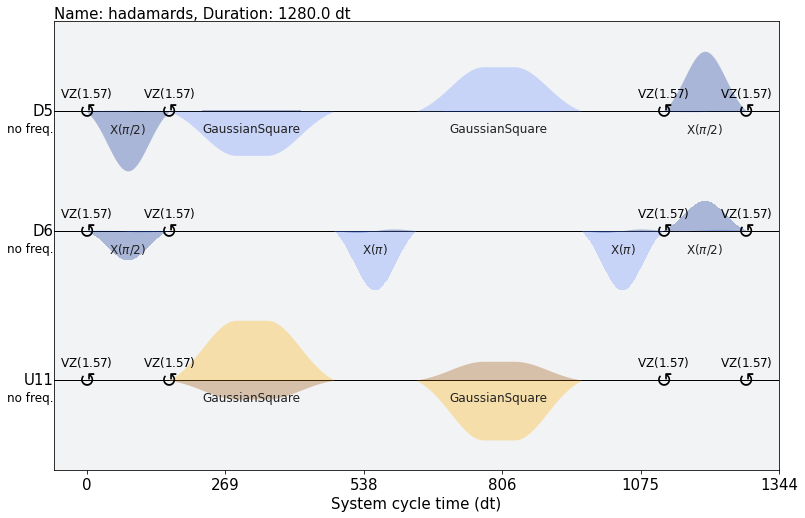

In [8]:
backend.defaults().instruction_schedule_map.get(GATE_NAME, (QUBITS[1], QUBITS[2]), theta=0.8).draw()

# Build Circuits

In [9]:
import libpulse

## Pulse Scheduled

In [10]:
def get_depth4_pulse(t):

    g1 = qk.circuit.Gate(GATE_NAME, 2, params=[2 * libpulse.depth4.t1(t)])
    g2 = qk.circuit.Gate(GATE_NAME, 2, params=[2 * libpulse.depth4.t2(t)])

    qregs = qk.QuantumRegister(backend.configuration().n_qubits)
    qc = qk.QuantumCircuit(qregs)

    qc.append(g1, (qregs[QUBITS[0]], qregs[QUBITS[1]]))
    qc.append(g2, (qregs[QUBITS[1]], qregs[QUBITS[2]]))
    qc.append(g2, (qregs[QUBITS[0]], qregs[QUBITS[1]]))
    qc.append(g1, (qregs[QUBITS[1]], qregs[QUBITS[2]]))

    return qc

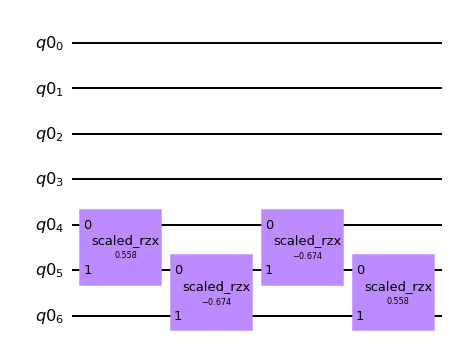

In [9]:
get_depth4_pulse(.2).draw("mpl")

In [10]:
# we don't need to do any complicated transpiling as the backend knows about the gates already!
various_cases = [
    qk.compiler.schedule(get_depth4_pulse(.2), backend),
    qk.compiler.schedule(qk.compiler.transpile(get_depth4_pulse(.2), backend), backend),
    qk.compiler.schedule(qk.compiler.transpile(get_depth4_pulse(.2), backend, backend.configuration().basis_gates), backend),
    qk.compiler.schedule(qk.compiler.transpile(get_depth4_pulse(.2), backend, backend.configuration().basis_gates), backend, backend.defaults().instruction_schedule_map)
]
assert all(cases == various_cases[0] for cases in various_cases), "compilation methods don't all yield same outcome!"

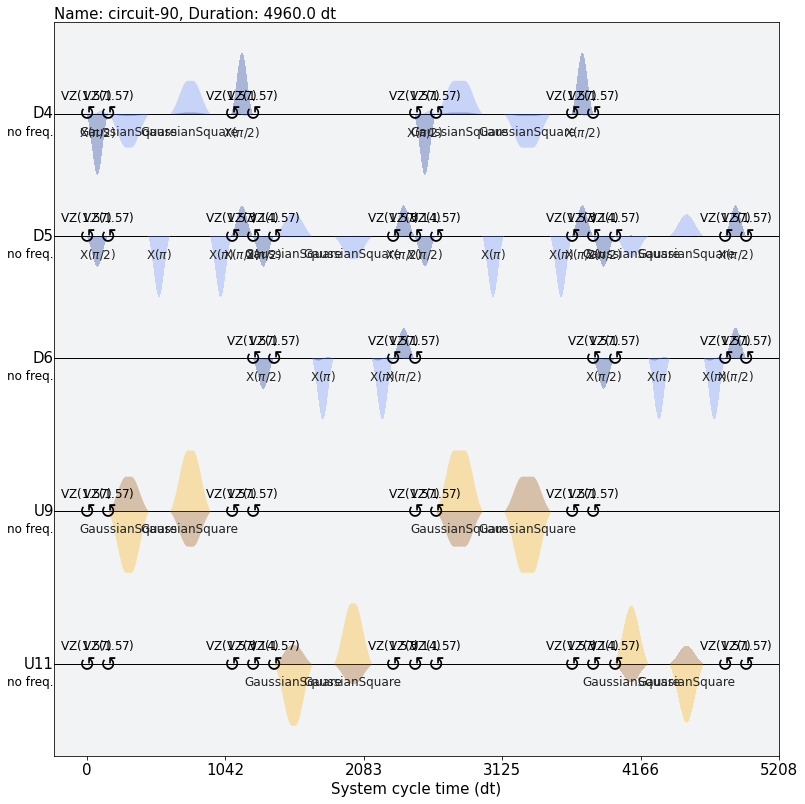

In [11]:
qk.compiler.schedule(get_depth4_pulse(.2), backend).draw()

## Reference Circuit

In [11]:
def get_depth4_reference(t):
    t1 = libpulse.depth4.t1(t)
    t2 = libpulse.depth4.t2(t)
    qregs = qk.QuantumRegister(3)
    ideal_circ = qk.QuantumCircuit(qregs)

    ideal_circ.rzx(2 * t1, qregs[0], qregs[1])
    ideal_circ.rzx(2 * t2, qregs[1], qregs[2])
    ideal_circ.rzx(2 * t2, qregs[0], qregs[1])
    ideal_circ.rzx(2 * t1, qregs[1], qregs[2])

    return ideal_circ

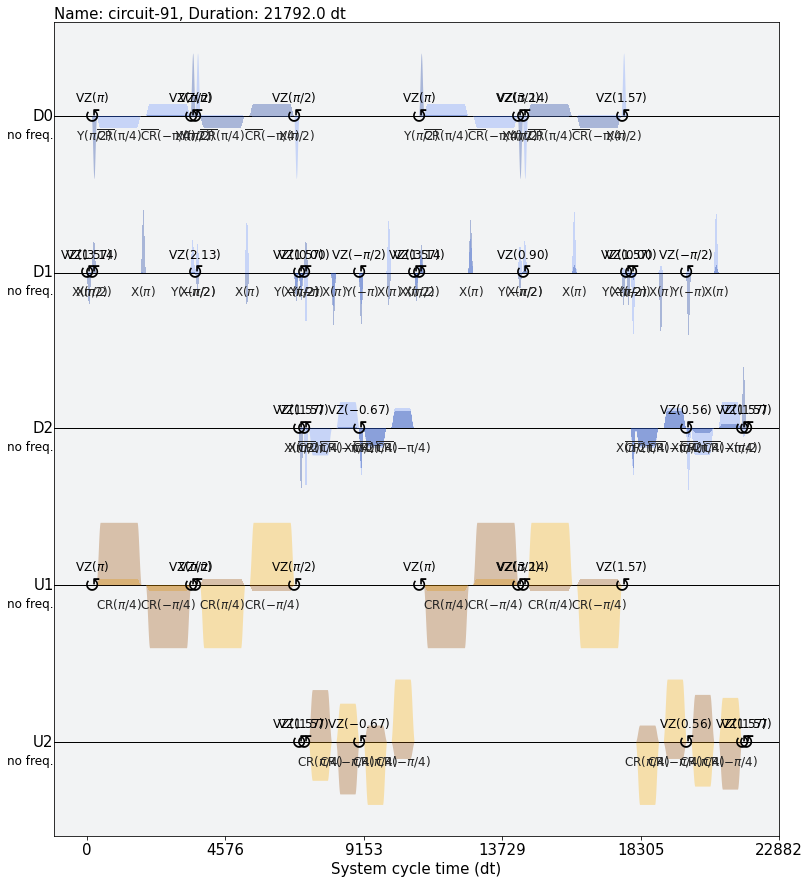

In [13]:
qk.compiler.schedule(qk.compiler.transpile(get_depth4_reference(.2), backend), backend).draw()

In [14]:
# angles15 =  [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
# angles14 =  [0.1, 0.2,0.3, 0.4, 0.6, 0.8, 1.0]

## Run Tomography Experiments

In [12]:
import zlib

def compress(obj):
    return zlib.compress(pickle.dumps(obj))
def uncompress(obj):
    return pickle.loads(zlib.decompress(obj))

In [13]:
import qiskit.quantum_info as qkqi
import qiskit.ignis.verification.tomography as qktomo

In [18]:
def precompute_circuits_and_schedules(circuit_factory, angles: list):
    experiments = {}

    for angle in angles:
        print(f"preparing circuit for {angle=}")
        qc = circuit_factory(angle)

        circuits = qktomo.process_tomography_circuits(qc, QUBITS)
        circuits_transpiled = qk.compiler.transpile(circuits, backend)  # transpile for process tomography circuits
        schedules = qk.compiler.schedule(circuits_transpiled, backend)

        experiments[angle] = compress({
            "pre_transpiled_circuits": circuits,
            "transpiled_circuits": circuits_transpiled,
            "qpt_schedules": schedules,
        })

    return experiments


In [19]:
ANGLES = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
qpt_experiments = precompute_circuits_and_schedules(get_depth4_pulse, ANGLES)

preparing circuit for angle=0.025
/home/johannes/miniconda3/envs/PC-zzz/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/home/johannes/miniconda3/envs/PC-zzz/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/johannes/miniconda3/envs/PC-zzz/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the c

In [20]:
LABEL = "16.June"
with open(f"results/{backend.name()}/{LABEL}/depth4/qpt_exps.q4q5q6.pickle", "wb") as f:
    pickle.dump(qpt_experiments, f, protocol=pickle.HIGHEST_PROTOCOL)

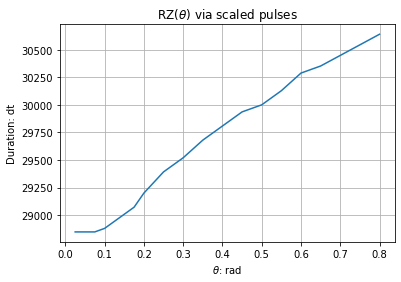

In [23]:
# measurement pulse really dominates!!!!
qpt_schedule_durations = [
    uncompress(qpt_experiments[angle])["qpt_schedules"][0].duration for angle in ANGLES
]

plt.plot(ANGLES, qpt_schedule_durations)
plt.xlabel(r"$\theta$: rad")
plt.ylabel("Duration: dt")
plt.title(r"RZ($\theta$) via scaled pulses")
plt.grid()

plt.savefig("plots/depth4_cost.png", transparent=False)
plt.show()

In [55]:
results = {}

In [120]:
for angle in ANGLES:
    print(f"running circuit for {angle=}")

    qpt_sched1 = qpt_experiments[str(angle)]["qpt_schedules"][0:900]
    job1 = execute(qpt_sched1, backend=backend, shots=100)  # ,mode='dedicated')

    qpt_sched2 = qpt_experiments[str(angle)]["qpt_schedules"][900:]
    job2 = execute(qpt_sched2, backend=backend, shots=100)  # ,mode='dedicated')

    result1 = job1.result()
    result2 = job2.result()

    result3 = result1
    result3.results = result1.results + result2.results

    results[angle] = (result1, result2, result3)

    with open(
        f"results/{device_name}/{label}/depth4/{angle}.q4q5q6.pickle", "wb"
    ) as handle:
        pickle.dump(result3, handle, protocol=pickle.HIGHEST_PROTOCOL)

0.075


In [ ]:
with open(
    f"results/{device_name}/{label}/depth4/full_results.q4q5q6.pickle", "wb"
) as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analysis

In [14]:
LABEL = "16.June"

with open(f"results/{backend.name()}/{LABEL}/depth4/full_results.q4q5q6.pickle", "rb") as handle:
    results = pickle.load(handle)
    LABEL = "16.June"

with open(f"results/{backend.name()}/{LABEL}/depth4/qpt_exps.q4q5q6.pickle", "rb") as handle:
    qpt_experiments = pickle.load(handle)

In [15]:
ANGLES = sorted([ float(k) for k in results.keys() ])
assert ANGLES == sorted([ float(k) for k in qpt_experiments.keys() ])

In [24]:
def fidelity_for(circuits, results, ideal_circuit) -> float:
    process_data = qktomo.ProcessTomographyFitter(results, circuits, meas_basis="Pauli", prep_basis="Pauli")
    choi_fit = process_data.fit(method="cvx", standard_weights=True, psd=True)
    choi_fit = choi_fit.data

    ideal_op_data = qkqi.Operator(ideal_circuit).data

    fid = qkqi.process_fidelity(channel=qkqi.Choi(choi_fit), target=qkqi.Operator(ideal_op_data))
    return fid

In [25]:
fidelities16 = {}

for angle in ANGLES:
    print(f"fitting {angle=}")
    
    circuits = uncompress(qpt_experiments[float(angle)])["transpiled_circuits"]
    res = results[str(angle)][2]
    ideal_circuit = get_depth4_reference(angle)

    fidelities16[angle] = fidelity_for(circuits, res, ideal_circuit)

fitting angle=0.025
Input channel is not CP. Choi-matrix has negative eigenvalues: [-9.72979072e-05 -8.55331072e-05 -8.01790596e-05 -7.59792000e-05
 -7.22594336e-05 -6.42325002e-05 -5.94414848e-05 -5.69616590e-05
 -5.38385121e-05 -5.07156603e-05 -4.88455115e-05 -4.50713300e-05
 -4.31564887e-05 -4.01521031e-05 -3.89383810e-05 -3.56918530e-05
 -3.20231597e-05 -2.78929005e-05 -2.55126135e-05 -2.39969773e-05
 -2.07276495e-05 -1.61859792e-05 -1.60000458e-05 -1.20981499e-05
 -6.23344969e-06 -5.29851938e-06 -2.76500122e-06]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-6.37468203e-05 -3.69896028e-05 -1.73841691e-05 -7.52346995e-06
  6.50978421e-06  1.67254987e-05  2.99818008e-05  4.91105977e-05]
fitting angle=0.05
Input channel is not CP. Choi-matrix has negative eigenvalues: [-1.23047597e-04 -1.12105200e-04 -1.06244733e-04 -1.02734682e-04
 -9.82117911e-05 -9.17027661e-05 -8.87410834e-05 -8.04637315e-05
 -7.50491149e-05 -7.02871501e-05 -6.37747457e-05 -5.94052589e-05
 -5

In [125]:
label = "16.June"
with open(f"results/{device_name}/{label}/depth4/full_fidelities.q4q5q6.pickle", "wb") as handle:
    pickle.dump(fidelities16, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
keys = sorted(results.keys())

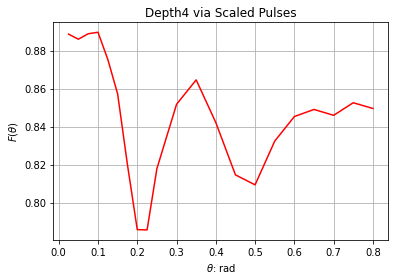

In [30]:
plt.plot([float(k) for k in keys], [fidelities16[float(k)] for k in keys], c="r")
plt.xlabel(r"$\theta$: rad")
plt.ylabel(r"$F(\theta)$")
plt.title(r"Depth4 via Scaled Pulses")
plt.grid()
#plt.savefig(f"plots/depth4.{label}.png", transparent=False)